# Sharing demos with others

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install gradio

# Polishing your Gradio demo:

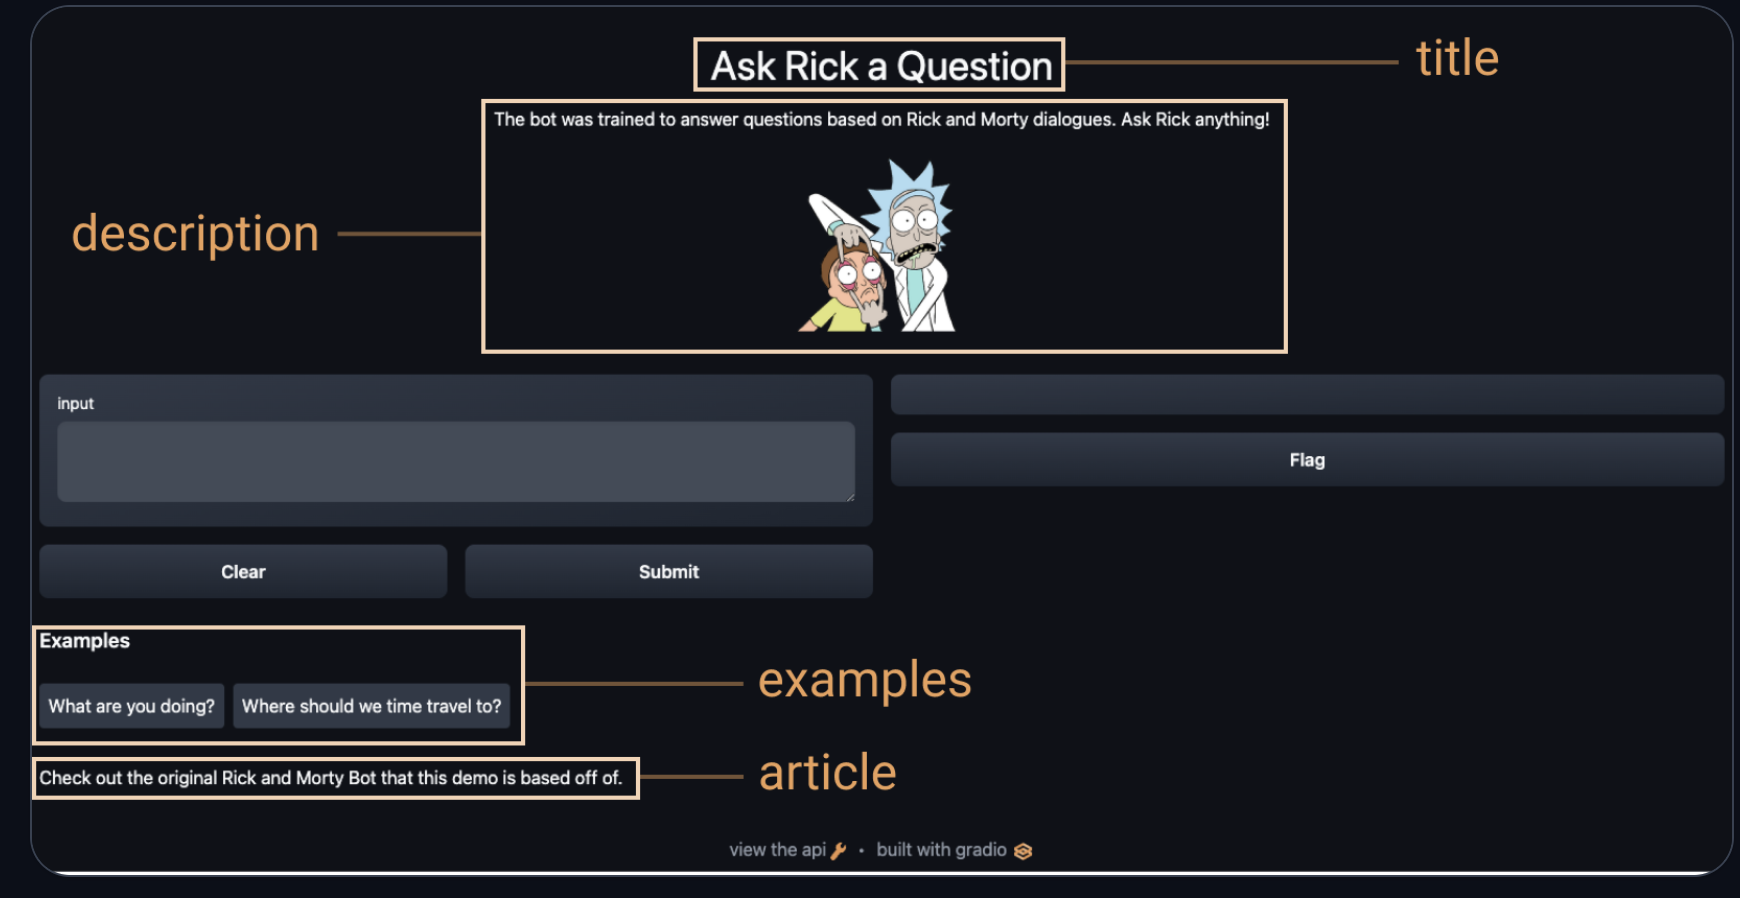

To add additional content to your demo, the Interface class supports some optional parameters:

- title: you can give a title to your demo, which appears above the input and output components.
- description: you can give a description (in text, Markdown, or HTML) for the interface, which appears above the input and output components and below the title.
- article: you can also write an expanded article (in text, Markdown, or HTML) explaining the interface. If provided, it appears below the input and output components.
- theme: don’t like the default colors? Set the theme to use one of default, huggingface, grass, peach. You can also add the dark- prefix, e.g. dark-peach for dark theme (or just dark for the default dark theme).
- examples: to make your demo way easier to use, you can provide some example inputs for the function. These appear below the UI components and can be used to populate the interface. These should be provided as a nested list, in which the outer list consists of samples and each inner list consists of an input corresponding to each input component.
- live: if you want to make your demo “live”, meaning that your model reruns every time the input changes, you can set live=True. This makes sense to use with quick models (we’ll see an example at the end of this section) Using the options above, we end up with a more complete interface.

Run the code below so you can chat with Rick and Morty:

In [ ]:
title = "Ask Rick a Question"
description = """
The bot was trained to answer questions based on Rick and Morty dialogues. Ask Rick anything!
<img src="https://huggingface.co/spaces/course-demos/Rick_and_Morty_QA/resolve/main/rick.png" width=200px>
"""

article = "Check out [the original Rick and Morty Bot](https://huggingface.co/spaces/kingabzpro/Rick_and_Morty_Bot) that this demo is based off of."

gr.Interface(
    fn=predict,
    inputs="textbox",
    outputs="text",
    title=title,
    description=description,
    article=article,
    examples=[["What are you doing?"], ["Where should we time travel to?"]],
).launch()

# Sharing your demo with temporary links
Now that we have a working demo of our machine learning model, let’s learn how to easily share a link to our interface. Interfaces can be easily shared publicly by setting `share=True` in the `launch()` method:


This generates a public, shareable link that you can send to anybody! When you send this link, the user on the other side can try out the model in their browser for up to 72 hours. Because the processing happens on your device (as long as your device stays on!), you don’t have to worry about packaging any dependencies. If you’re working out of a Google Colab notebook, a share link is always automatically created. It usually looks something like this: XXXXX.gradio.app. Although the link is served through a Gradio link, we are only a proxy for your local server, and do not store any data sent through the interfaces.

Keep in mind, however, that these links are publicly accessible, meaning that anyone can use your model for prediction! Therefore, make sure not to expose any sensitive information through the functions you write, or allow any critical changes to occur on your device. If you set `share=False` (*the default*), only a local link is created.

In [ ]:
gr.Interface(classify_image, "image", "label").launch(share=True)

# Hosting your demo on Hugging Face Spaces
A share link that you can pass around to collegues is cool, but how can you permanently host your demo and have it exist in its own `“space”` on the internet?

Hugging Face Spaces provides the infrastructure to permanently host your Gradio model on the internet, for free! Spaces allows you to create and push to a (public or private) repo, where your Gradio interface code will exist in an `app.py` file. Read a step-by-step tutorial to get started, or watch an example video below.

# ✏️ Let’s apply it!
Using what we just learned in the sections so far, let’s create the `sketch recognition demo` we saw in section one of this chapter. Let’s add some customization to our interface and set `share=True` to create a public link we can pass around.

We can load the labels from `class_names.txt `and load the pre-trained pytorch model from `pytorch_model.bin`. Download these files by following the link and clicking download on the top left corner of the file preview. Let’s take a look at the code below to see how we use these files to load our model and create a `predict()` function:


In [ ]:
from pathlib import Path
import torch
import gradio as gr
from torch import nn

LABELS = Path("class_names.txt").read_text().splitlines()

model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(1152, 256),
    nn.ReLU(),
    nn.Linear(256, len(LABELS)),
)
state_dict = torch.load("pytorch_model.bin", map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()


def predict(im):
    x = torch.tensor(im, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    with torch.no_grad():
        out = model(x)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)
    values, indices = torch.topk(probabilities, 5)
    return {LABELS[i]: v.item() for i, v in zip(indices, values)}

Notice the `live=True `parameter in Interface, which means that the sketch demo makes a prediction every time someone draws on the sketchpad (no submit button!).

Furthermore, we also set the `share=True` argument in the `launch() `method. This will create a public link that you can send to anyone! When you send this link, the user on the other side can try out the sketch recognition model. To reiterate, you could also host the model on Hugging Face Spaces, which is how we are able to embed the demo above.

In [ ]:
interface = gr.Interface(
    predict,
    inputs="sketchpad",
    outputs="label",
    theme="huggingface",
    title="Sketch Recognition",
    description="Who wants to play Pictionary? Draw a common object like a shovel or a laptop, and the algorithm will guess in real time!",
    article="<p style='text-align: center'>Sketch Recognition | Demo Model</p>",
    live=True,
)
interface.launch(share=True)

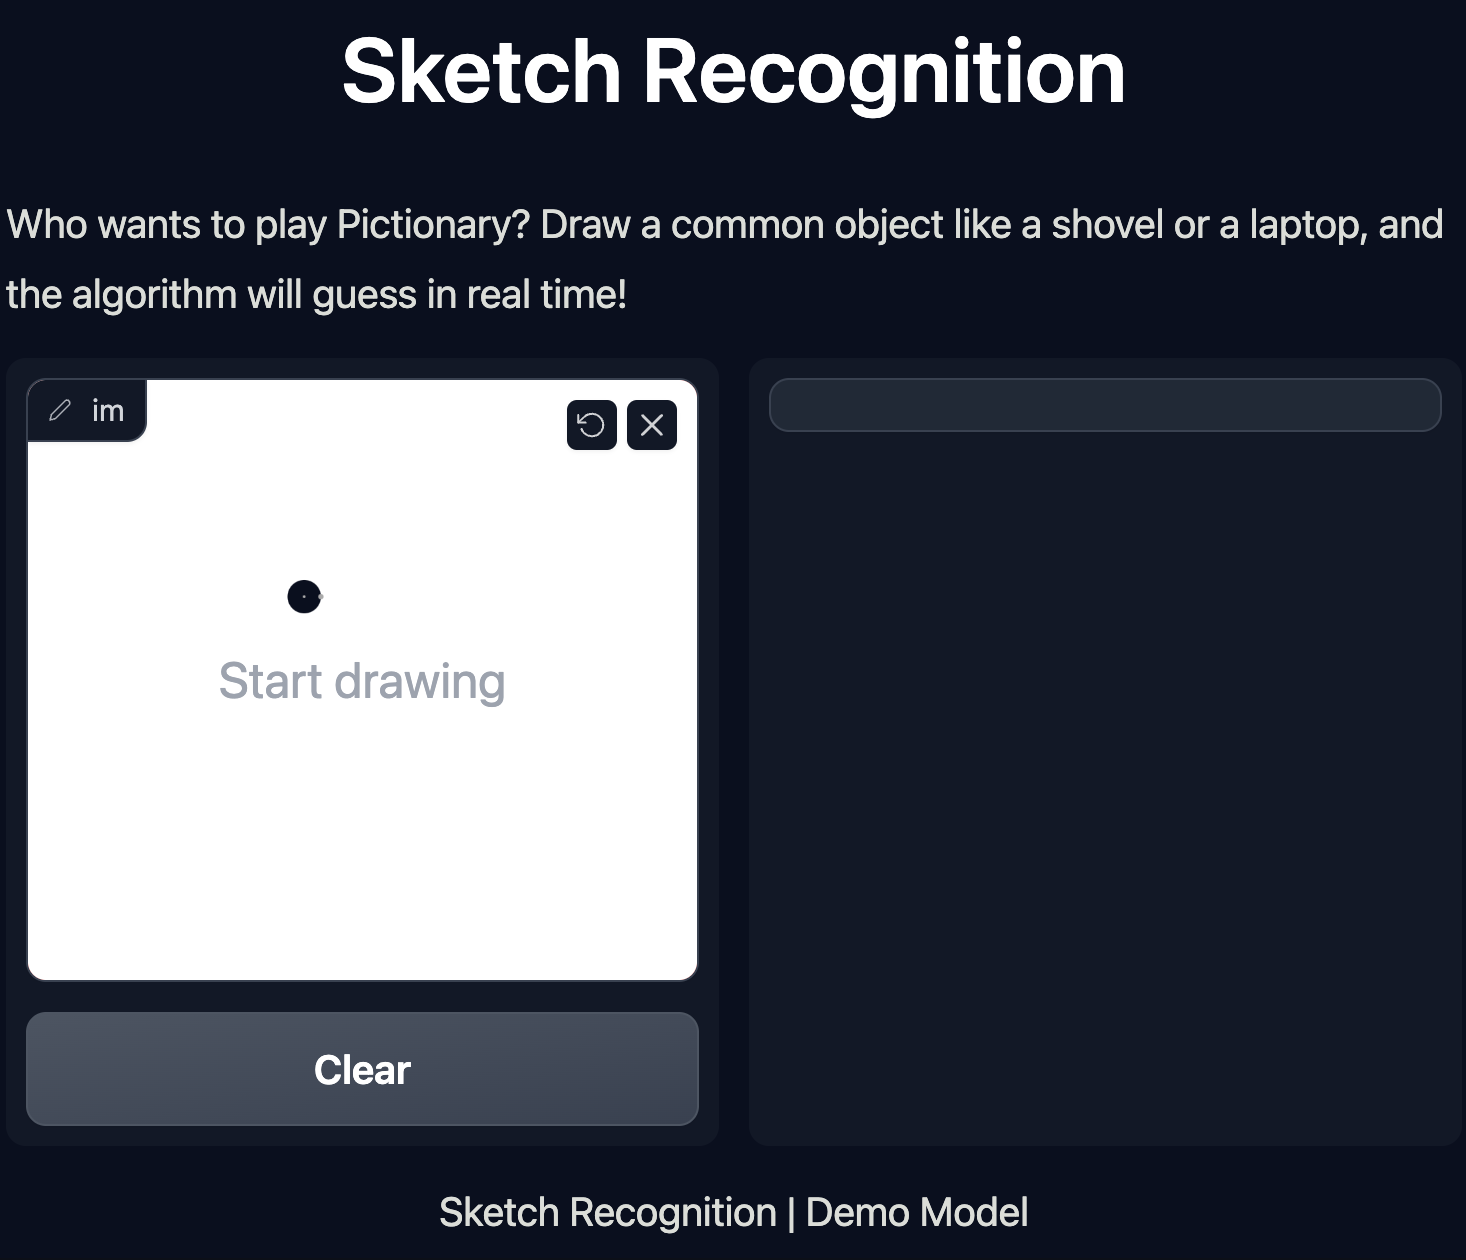